In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_04 import *

# Get data

In [3]:
x_train,y_train,x_valid,y_valid= get_data_normalized()

train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

bs,nh,c

(512, 50, 10)

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [6]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

In [7]:
learn.model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [8]:
??get_model

In [9]:
run.fit(3, learn)

train: [0.5577766276041667, tensor(0.8256)]
valid: [0.669927392578125, tensor(0.7825)]
train: [0.28654114583333334, tensor(0.9106)]
valid: [0.803721533203125, tensor(0.7542)]
train: [0.225734423828125, tensor(0.9308)]
valid: [0.561067529296875, tensor(0.8346)]


In [10]:
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [11]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])
run.fit(3, learn)

train: [0.6169501302083333, tensor(0.8090)]
valid: [0.85099111328125, tensor(0.7274)]
train: [0.33114075520833336, tensor(0.8997)]
valid: [0.665252734375, tensor(0.7955)]
train: [0.2639566731770833, tensor(0.9200)]
valid: [0.58142744140625, tensor(0.8252)]


# Scheduler callback for params

In [21]:
run.epochs

3

In [22]:
run.n_epochs

2.9999999999999973

In [18]:
len(learn.opt.param_groups)

1

In [14]:
learn.opt.param_groups[0].keys() # list of params we can schedule

dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov'])

In [19]:
learn.opt.param_groups[0]['lr']

0.3

In [15]:
learn.opt.param_groups[0]['params'][0].shape

torch.Size([50, 784])

In [17]:
learn.opt.param_groups[0]['params'][1].shape

torch.Size([50])

In [24]:
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[] 

    def after_batch(self): # save learning rate (of only last groups) and loss after training each batch
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr']) # get lr of last groups and append to lrs
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups: # we could specify to have > 1 groups in pytorch opt param groups
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs) # sched_func receives a 'pos' (position)
            # e.g. train 3 epochs, at epoch 0 and 50% of the batches (self.n_epochs=0.5,self.epochs=3)
            # -> position = 0.5/3 = .16 (16% through)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

Simple linear schedule. Lr (or any params) will reach from start to end in linear rate. Form: a+ bx, with x in [0,1]

```python
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)
```

Function decorators: wrappers to existing functions, to add new functionality to existing functions

In [41]:
# example
def p_decorate(func):
    def func_wrapper(inner_name):
        return "<p>{0}</p>".format(func(inner_name))
    return func_wrapper

def div_decorate(func):
    def func_wrapper(inner_name):
        return "<div>{0}</div>".format(func(inner_name))
    return func_wrapper

@p_decorate
def get_text(name): 
    # get_text function is passed as 'func' in p_decorate
    # 'name' params is passed into func_wrapper, which is then processed by 'func' to get the lorem ipsum
    # then finally wrapped with <p> tag and return as string
    # In the end, func_wrapper is the real function that is called
    return "lorem ipsum, {0} dolor sit amet".format(name)

@div_decorate
@p_decorate
def get_text_2(name):
    return "lorem ipsum, {0} dolor sit amet".format(name)

In [44]:
get_text

<function __main__.p_decorate.<locals>.func_wrapper(inner_name)>

In [42]:
print(get_text("John"))
print(get_text_2("John"))

<p>lorem ipsum, John dolor sit amet</p>
<div><p>lorem ipsum, John dolor sit amet</p></div>


Now create a sched function with @annealer decorator

In [14]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [38]:
f = sched_lin(1,2) 
# _inner(start,end) is called, that's why we only need 2 params input (start and end)
# then it returns the partial func of sched_lin (which requires 3 param inputs) with start and end as default params input. 
# Therefore we only need to give this partial func of sched_lin the last inputs it needs: pos (b/t 0 and 1 as pct)
f(0.3)

1.3

# Different scheduler functions

Now let's add other scheduler

In [15]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

In [16]:
#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape)) # x is the torch.Tensor itself
# torch.Tensor.ndim = property(temp_func)

Wait, what is ```property```?

Syntax: property(fget, fset, fdel, doc)

Parameters:

fget() – used to get the value of attribute

fset() – used to set the value of atrribute

fdel() – used to delete the attribute value

doc() – string that contains the documentation (docstring) for the attribute

Return: Returns a property attribute from the given getter, setter and deleter.

In [121]:
temp = torch.Tensor([[1,2],[4,5],[7,8]])

In [122]:
temp.shape

torch.Size([3, 2])

In [119]:
# temp.ndim

<class 'torch.Tensor'>
tensor([[1., 2.],
        [4., 5.],
        [7., 8.]])


2

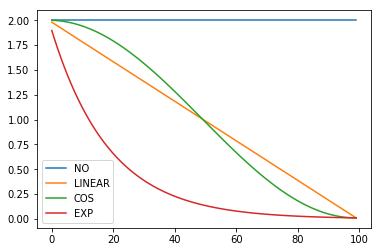

In [17]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100) # just iteration to plot
p = torch.linspace(0.01,1,100) # pos input

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

# Adding custom scheduler to combine different schedulers together

In [18]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [19]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [20]:
sched

<function __main__.combine_scheds.<locals>._inner(pos)>

In [21]:
sched(0.2)

0.5249999807287408

In [22]:
sched(0.3)

0.5999999999999992

In [23]:
sched(0.8)

0.27530203155090127

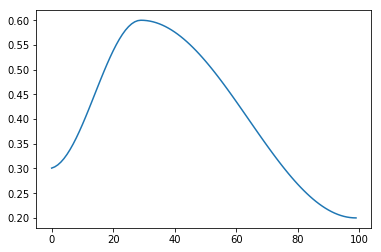

In [24]:
plt.plot(a, [sched(o) for o in p])

# Train model with lr schedule + recorder callbacks

In [143]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.8), sched_cos(0.8, 0.2)])

In [144]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [145]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [139]:
run.cbs

In [146]:
run.fit(3, learn)

train: [0.6689610677083333, tensor(0.7947)]
valid: [0.8156572265625, tensor(0.7495)]
train: [0.2799543294270833, tensor(0.9137)]
valid: [0.58595029296875, tensor(0.8186)]
train: [0.19406559244791666, tensor(0.9429)]
valid: [0.50471826171875, tensor(0.8513)]


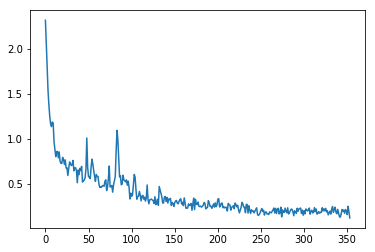

In [147]:
run.recorder.plot_loss() #validation nll loss

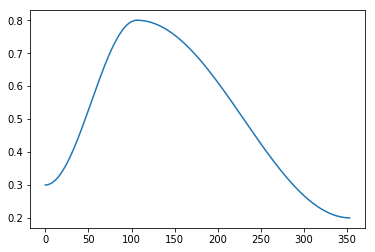

In [148]:
run.recorder.plot_lr()

# Rewrite recorder and param scheduler for discriminative learning rate?

Old code for recorder and param scheduler

```python
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[] 

    def after_batch(self): # save learning rate (of only last groups) and loss after training each batch
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr']) # get lr of last groups and append to lrs
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups: # we could specify to have > 1 groups in pytorch opt param groups
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs) # sched_func receives a 'pos' (position)
            # e.g. train 3 epochs, at epoch 0 and 50% of the batches (self.n_epochs=0.5,self.epochs=3)
            # -> position = 0.5/3 = .16 (16% through)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()
```

In [40]:
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups] # store lr of every groups
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr']) # store lr of every groups
        
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs): # different sched func for each group
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [41]:
m = data.train_ds.x.shape[1]
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))

In [42]:
m

784

In [43]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [45]:
for l in model:
    print(l)
    print(type(l))

Linear(in_features=784, out_features=50, bias=True)
<class 'torch.nn.modules.linear.Linear'>
ReLU()
<class 'torch.nn.modules.activation.ReLU'>
Linear(in_features=50, out_features=10, bias=True)
<class 'torch.nn.modules.linear.Linear'>


In [46]:
wgts,biases = [],[]

for l in model:
    if hasattr(l,'weight'): wgts  .append(l.weight)
    if hasattr(l,'bias'  ): biases.append(l.bias  )

In [52]:
len(wgts), wgts[0].shape, wgts[1].shape

(2, torch.Size([50, 784]), torch.Size([10, 50]))

In [53]:
len(biases),biases[0].shape,biases[1].shape

(2, torch.Size([50]), torch.Size([10]))

In [67]:
# all of the above is equivalent to this
for i in model.parameters():
    print(type(i))
    print(i.shape)

<class 'torch.nn.parameter.Parameter'>
torch.Size([50, 784])
<class 'torch.nn.parameter.Parameter'>
torch.Size([50])
<class 'torch.nn.parameter.Parameter'>
torch.Size([10, 50])
<class 'torch.nn.parameter.Parameter'>
torch.Size([10])


In [59]:
def pg_dicts(pgs): return [{'params':o} for o in pgs]

In [60]:
pgs = pg_dicts((wgts,biases))

In [65]:
len(pgs),pgs[1]['params']

(2, [Parameter containing:
  tensor([-5.0116e-05,  2.9846e-02, -3.1293e-03,  1.8170e-02,  2.4892e-03,
          -3.1409e-04, -3.0453e-02, -9.9156e-03, -1.8177e-02, -8.6449e-03,
          -1.2010e-02,  2.6193e-02, -2.0456e-02,  2.8179e-02,  3.2148e-02,
           1.6270e-02, -2.4329e-02, -2.9285e-02,  5.3867e-03,  8.4731e-04,
          -3.5161e-02,  2.7903e-02, -6.2268e-03,  1.8218e-02, -3.3400e-02,
          -1.9339e-02, -2.1185e-02,  4.1198e-03,  1.5062e-02,  2.5820e-02,
           2.3367e-02,  1.5048e-02,  2.1898e-02, -3.2550e-02,  3.0170e-02,
          -2.7533e-02, -3.5530e-02, -1.4643e-02,  6.3130e-03, -7.6273e-03,
          -3.3815e-02, -2.3595e-02, -2.3721e-02, -1.3868e-02, -1.5091e-02,
           1.0159e-02, -4.8003e-04, -1.6990e-02,  3.4147e-02,  3.0409e-02],
         requires_grad=True), Parameter containing:
  tensor([ 0.0554,  0.1127,  0.1016,  0.1086,  0.0741, -0.1348,  0.0824,  0.0602,
           0.0786,  0.0105], requires_grad=True)])

In [68]:
pgs[0]['params'][0].shape,pgs[0]['params'][1].shape # store weights at pgs[0]

(torch.Size([50, 784]), torch.Size([10, 50]))

In [66]:
pgs[1]['params'][0].shape,pgs[1]['params'][1].shape # store biases at pgs[1]

(torch.Size([50]), torch.Size([10]))

In [69]:
opt = optim.SGD(pgs, lr=0.1)
learn = Learner(model, opt, loss_func, data)

Check opt.param_groups

In [74]:
len(opt.param_groups)

2

In [79]:
opt.param_groups[0].keys()

dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov'])

Params in opt are stored in the same way as the pgs list, which contains 2 dict

In [80]:
type(opt.param_groups[0])

dict

In [77]:
opt.param_groups[0]['params'][0].shape,opt.param_groups[0]['params'][1].shape # store weights at pgs[0]

(torch.Size([50, 784]), torch.Size([10, 50]))

In [81]:
opt.param_groups[1]['params'][0].shape,opt.param_groups[1]['params'][1].shape # store biases at pgs[1]

(torch.Size([50]), torch.Size([10]))

Replace: sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.8), sched_cos(0.8, 0.2)])

In [71]:
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [72]:
phases = [0.3, 0.7]
sched_w = combine_scheds(phases, cos_1cycle_anneal(0.3, 0.6, 0.2)) 
sched_b = combine_scheds(phases, cos_1cycle_anneal(0.9, 1.8, 0.6))

In this example we will have 2 params group (for demonstration purposes), 1 group for lr schedule on weights, 1 group for lr schedule on biases 

In [83]:
def create_scheds(pct_first, sched_func, starts, highs, ends):
    phases = [pct_first, 1-pct_first]
    return [
        combine_scheds(phases, [sched_func(s,h), sched_func(h,e)]) for s,h,e in zip(starts,highs,ends)
    ]

In [84]:
scheds = create_scheds(0.3, sched_cos, (0.3,0.9), (0.6,1.8), (0.2,0.6))
# group 1 params go from .3 to .6 to .2
# group 2 params go from .9 to 1.8 to .6

In [85]:
scheds

[<function __main__.combine_scheds.<locals>._inner(pos)>,
 <function __main__.combine_scheds.<locals>._inner(pos)>]

In [86]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', scheds)]

In [87]:
run = Runner(cb_funcs=cbfs)

run.fit(3, learn)

train: [0.6285057942708333, tensor(0.8074)]
valid: [0.75274501953125, tensor(0.7561)]
train: [0.2894345703125, tensor(0.9118)]
valid: [0.5459787109375, tensor(0.8367)]
train: [0.21156778971354168, tensor(0.9371)]
valid: [0.493471923828125, tensor(0.8565)]


Plot lr for 2 groups

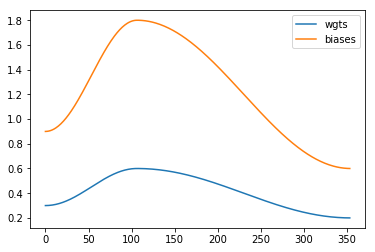

In [88]:
plt.plot(run.recorder.lrs[0])
plt.plot(run.recorder.lrs[1])
plt.legend(['wgts','biases']);